[TTL page](https://towardsdatascience.com/response-optimization-with-design-of-experiments-and-python-63f9afb3f26f)

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

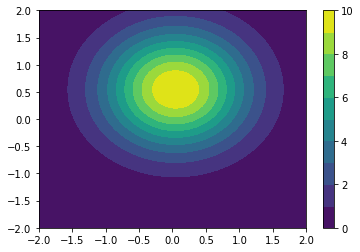

In [16]:
def gaussian_function(x, y, pars=None):
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)

    return func, x0, y0, fwhm
    

    
# random select a surface with linear gradient

x = np.round(np.linspace(-2,2,101),2)
y = np.round(np.linspace(-2,2,101),2)
X, Y = np.meshgrid(x,y)
Z, x0, y0, fwhm = gaussian_function(X,Y)
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.show()

In [17]:
def output_model(x_d1, y_d1, model=None, pars=None, cnt_point=True):

    temp_df = pd.DataFrame([(i,j) for i in x_d1 for j in y_d1], columns=['x','y'])

    if cnt_point:
        temp_df.loc[len(temp_df)] = [temp_df['x'].mean(),temp_df['y'].mean()]
        
    temp_df = normal_to_coded_var(temp_df)    
    temp_df['outcome'] = temp_df.apply(lambda x: gaussian_function(x['x'], x['y'], pars)[0], axis=1)
    
    if model:
        temp_df['predict'] = model.predict(temp_df[['x','y']])
        temp_df['mape'] = 100*(temp_df['outcome'] - temp_df['predict'])/temp_df['outcome']
        
    return temp_df
    
def normal_to_coded_var(temp_df, output_pars = False):
        
    mean_x = temp_df['x'].mean()
    mean_y = temp_df['y'].mean()
    range_x = temp_df['x'].max()-temp_df['x'].min()
    range_y = temp_df['y'].max()-temp_df['y'].min()
    
    temp_df['cX'] = (temp_df['x']-mean_x)/(range_x/2)
    temp_df['cY'] = (temp_df['y']-mean_y)/(range_y/2)
    
    if output_pars:
        return mean_x, mean_y, range_x, range_y
    
    return temp_df

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline


def linear_pipe_fit(degree=2, interaction=True, dataframe=pd.DataFrame(), input_vars=['cX','cY']):
    
    lr = LinearRegression()
    pol = PolynomialFeatures(degree=degree, interaction_only=interaction, include_bias=False)
    pipe = Pipeline([('pol',pol), ('lr', lr)])
    pipe.fit(dataframe[input_vars], dataframe['outcome'])
    
    return pipe

In [19]:
def next_step(model=None, increment_y = 1, step_x = 0.125, step_y = 0.125, dataframe=pd.DataFrame()):
    
    mean_x, mean_y, range_x, range_y = normal_to_coded_var(dataframe, output_pars = True)
    coef_x = model['lr'].coef_[0]
    coef_y = model['lr'].coef_[1]
    ratio = coef_x/coef_y
    
    print(f'coef x {coef_x:.2f} and coef y {coef_y:.2f}')
    
    increment_x = np.abs(ratio)*increment_y*np.sign(coef_x)
    increment_y = increment_y*np.sign(coef_y)
    
    print(f'increment x {increment_x:.2f} and increment y {increment_y:.2f} with ratio {ratio:.2f}')
    
    base_x = increment_x*(range_x/2)+mean_x
    base_y = increment_y*(range_y/2)+mean_y
    
    print(f'new x {base_x:.2f} and new y {base_y:.2f}')
                
    next_x = np.round(np.array([base_x-step_x, base_x+step_x]),2)
    next_y = np.round(np.array([base_y-step_y, base_y+step_y]),2)
    
    return next_x, next_y

In [24]:

# first full factorial
x_d1 = np.array([0.5,1])
y_d1 = np.array([-0.5,-1])
# generate the dataframe with experiments and their result
first_doe = output_model(x_d1, y_d1, pars=(x0, y0, fwhm), cnt_point=False)
# fit the model with second order polynomial with interactions only, the fit is done on the coded variables
pipe1 = linear_pipe_fit(degree=2, interaction=True, dataframe=first_doe, input_vars=['cX','cY'])
# plot the contour plot of the first design
# plot_contour_fromdf(first_doe, fill_value=0, model = pipe1, plot_normal_vars=True)
# generate the new coordinates based on the steepest path
x_d2, y_d2 = next_step(model=pipe1, increment_y = 2, dataframe=first_doe)

coef x -0.48 and coef y 0.82
increment x -1.17 and increment y 2.00 with ratio -0.58
new x 0.46 and new y -0.25


In [27]:
steps_df = pd.DataFrame()
x_t = np.array([0.5,1])
y_t = np.array([-0.5,-1])
for i in range(10):
    test_df = output_model(x_t, y_t, pars=(x0, y0, fwhm), cnt_point=False)
    test_df['iteration'] = i
    pipe1 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df, input_vars=['x','y'])
    x_t, y_t = next_step(pipe1, increment_y = 2, dataframe=test_df)
    #plot_contour_fromdf(test_df, fill_value=0, model = pipe1, plot_normal_vars=True)
    steps_df = steps_df.append(test_df)
    max_outcome = test_df['outcome'].max()
    
    if max_outcome < steps_df['outcome'].max():
        print(f'maximum found at iteration {i}')
        break
    print(x_t, y_t)

coef x -1.93 and coef y 3.30
increment x -1.17 and increment y 2.00 with ratio -0.58
new x 0.46 and new y -0.25
[0.33 0.58] [-0.38 -0.12]
coef x -3.54 and coef y 6.82
increment x -1.04 and increment y 2.00 with ratio -0.52
new x 0.33 and new y 0.01
[0.2  0.45] [-0.12  0.14]
coef x -3.53 and coef y 6.73
increment x -1.05 and increment y 2.00 with ratio -0.52
new x 0.19 and new y 0.27
[0.07 0.32] [0.15 0.4 ]
coef x -2.39 and coef y 4.31
increment x -1.11 and increment y 2.00 with ratio -0.55
new x 0.06 and new y 0.53
[-0.07  0.18] [0.4  0.65]
coef x -0.17 and coef y 0.35
increment x -0.93 and increment y 2.00 with ratio -0.47
new x -0.06 and new y 0.78
maximum found at iteration 4
